In [12]:
import csv
import json
import random
import sys
from typing import Dict

import numpy as np
from scipy.stats import linregress

import main
import matplotlib.pyplot as plt

from tva_io import scheme_by_name
from tva_types import Scheme

random.seed(42)

def generate_preferences_csv(num_voters: int, num_candidates: int, filename: str) -> None:
    candidates = [chr(65 + i) for i in range(num_candidates)]  # Candidate labels A, B, C, ...
    preferences = []
    for _ in range(num_voters):
        column = random.sample(candidates, num_candidates)
        preferences.append(column)
    preferences = list(zip(*preferences))  # Transpose the list to have each row represent a voter
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for preference in preferences:
            writer.writerow(preference)

def generate_biased_preferences_csv(num_voters: int, num_candidates: int, filename: str, x: float, y: float) -> None:
    top_candidates_count = round(num_candidates * x)
    votes_per_top_candidate = round(num_voters * y)

    candidates = [chr(65 + i) for i in range(num_candidates)]  # Candidate labels A, B, C, ...
    top_candidates = random.sample(candidates, top_candidates_count)
    other_candidates = [c for c in candidates if c not in top_candidates]

    preferences = []
    for _ in range(num_voters):
        top_preferences = random.sample(top_candidates, min(len(top_candidates), votes_per_top_candidate))
        other_preferences = random.sample(other_candidates, num_candidates - len(top_preferences))
        preferences.append(top_preferences + other_preferences)

    preferences = list(zip(*preferences))  # Transpose the list to have each row represent a voter

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for preference in preferences:
            writer.writerow(preference)
def read_output(filename: str) -> dict:
    with open(filename, 'r') as file:
        return json.load(file)

def get_happiness_by_scheme(output: dict, scheme: str) -> float:
    return output[scheme]["non_strategic_overall_happiness"]

def get_risk_by_scheme(output: dict, scheme: str) -> float:
    return output[scheme]["strategic_voting_risk"]

def calculate_averagem_happiness_increase_by_scheme(data, scheme):
    total_increase = 0
    voters_count = 0

    for voter_data in data[scheme]['voters'][0]:  # Assuming the first list contains relevant voter data
        increase = voter_data['voter_happiness'] - voter_data['true_voter_happiness']
        total_increase += increase
        voters_count += 1

    return total_increase / voters_count if voters_count > 0 else 0

def plot_strategic_voting_risk(data):
    risks = [details['strategic_voting_risk'] for scheme, details in data.items() if 'strategic_voting_risk' in details]
    schemes = [scheme for scheme in data if 'strategic_voting_risk' in data[scheme]]

    plt.bar(schemes, risks, color='skyblue')
    plt.xlabel('Voting Scheme')
    plt.ylabel('Strategic Voting Risk')
    plt.title('Strategic Voting Risk by Voting Scheme')
    plt.xticks(rotation=45)
    plt.show()


def run_experiment(candidate_numbers, voter_numbers, schemes):
    results = {num_candidates: {'happiness': [], 'risk': [], 'avg_increase': []} for num_candidates in candidate_numbers}

    for num_voters in voter_numbers:
        print(f"Running experiment for {num_voters} voters")
        for num_candidates in candidate_numbers:
            print(f"Number of candidates: {num_candidates}")
            # Generate preferences
            filename = f"exp_preferences.csv"
            generate_preferences_csv(num_voters, num_candidates, filename)

            # Run analysis
            output_filename = f"exp_output.json"
            main.main(schemes, [[]], filename, output_filename)
            output = read_output(output_filename)

            # Extract metrics for analysis
            happiness = get_happiness_by_scheme(output, "plurality")
            risk = get_risk_by_scheme(output, "plurality")
            avg_increase = calculate_average_happiness_increase_by_scheme(output, "plurality")

            # Store metrics by number of candidates for plotting against voter numbers
            results[num_candidates]['happiness'].append(happiness)
            results[num_candidates]['risk'].append(risk)
            results[num_candidates]['avg_increase'].append(avg_increase)

    return results, voter_numbers


def plot_combined_metrics(results, voter_numbers):
    num_plots = len(results.keys())
    fig, axs = plt.subplots(num_plots, 3, figsize=(15, num_plots * 5), squeeze=False)  # Ensure axs is always 2D

    candidate_numbers = list(results.keys())
    for idx, num_candidates in enumerate(candidate_numbers):
        metrics = results[num_candidates]

        # Adjust indexing based on the dimensionality of axs
        ax_happiness = axs[idx, 0] if axs.ndim > 1 else axs[0]
        ax_risk = axs[idx, 1] if axs.ndim > 1 else axs[1]
        ax_increase = axs[idx, 2] if axs.ndim > 1 else axs[2]

        ax_happiness.plot(voter_numbers, metrics["happiness"], marker='o', linestyle='-', color='blue')
        ax_happiness.set_title(f'Non-Strategic Overall Happiness (Candidates={num_candidates})')
        ax_happiness.set_xlabel('Number of Voters')
        ax_happiness.set_ylabel('Happiness')

        ax_risk.plot(voter_numbers, metrics["risk"], marker='o', linestyle='-', color='red')
        ax_risk.set_title(f'Strategic Voting Risk (Candidates={num_candidates})')
        ax_risk.set_xlabel('Number of Voters')
        ax_risk.set_ylabel('Risk')

        ax_increase.plot(voter_numbers, metrics["avg_increase"], marker='o', linestyle='-', color='green')
        ax_increase.set_title(f'Average Happiness Increase (Candidates={num_candidates})')
        ax_increase.set_xlabel('Number of Voters')
        ax_increase.set_ylabel('Happiness Increase')

    plt.tight_layout()
    plt.show()


def plot_combined_metrics_with_trends(results, voter_numbers):
    num_plots = len(results.keys())
    fig, axs = plt.subplots(num_plots, 3, figsize=(15, num_plots * 5), squeeze=False)  # Ensure axs is always 2D

    candidate_numbers = list(results.keys())
    for idx, num_candidates in enumerate(candidate_numbers):
        metrics = results[num_candidates]

        for ax, metric, color, title in zip(axs[idx, :],
                                            ['happiness', 'risk', 'avg_increase'],
                                            ['blue', 'red', 'green'],
                                            ['Non-Strategic Overall Happiness', 'Strategic Voting Risk',
                                             'Average Happiness Increase']):
            y_values = metrics[metric]
            # Linear regression for trend
            slope, intercept, _, _, _ = linregress(voter_numbers, y_values)
            trend_line = np.array(voter_numbers) * slope + intercept

            # Plot the trend line
            ax.plot(voter_numbers, trend_line, color=color, label=f'{title} Trend')
            # Optionally, plot the individual data points
            ax.scatter(voter_numbers, y_values, color=color, alpha=0.5, label='Data Points')

            ax.set_title(f'{title} (Candidates={num_candidates})')
            ax.set_xlabel('Number of Voters')
            ax.set_ylabel(title)
            ax.legend()

    plt.tight_layout()
    plt.show()
    
def plot_combined_metrics_with_nonlinear_trends(results, voter_numbers):
    num_plots = len(results.keys())
    fig, axs = plt.subplots(num_plots, 3, figsize=(15, num_plots * 5), squeeze=False)  # Ensure axs is always 2D

    candidate_numbers = list(results.keys())
    for idx, num_candidates in enumerate(candidate_numbers):
        metrics = results[num_candidates]

        for ax, metric, color, title in zip(axs[idx, :],
                                            ['happiness', 'risk', 'avg_increase'],
                                            ['blue', 'red', 'green'],
                                            ['Non-Strategic Overall Happiness', 'Strategic Voting Risk',
                                             'Average Happiness Increase']):
            y_values = metrics[metric]
            # Polynomial regression for trend
            coefficients = np.polyfit(voter_numbers, y_values, 2)
            polynomial = np.poly1d(coefficients)
            trend_line = polynomial(voter_numbers)

            # Plot the trend line
            ax.plot(voter_numbers, trend_line, color=color, label=f'{title} Trend')
            # Optionally, plot the individual data points
            ax.scatter(voter_numbers, y_values, color=color, alpha=0.5, label='Data Points')

            ax.set_title(f'{title} (Candidates={num_candidates})')
            ax.set_xlabel('Number of Voters')
            ax.set_ylabel(title)
            ax.legend()

    plt.tight_layout()
    plt.show()

In [13]:
scheme_names = ["plurality", "voting_for_two", "borda", "anti_plurality"]
collusion_groups = [[0, 3],[2],[1],[4]]

    # Set voting schemes
schemes: Dict[str, Scheme] = {}
scheme_names = scheme_names
for scheme_name in scheme_names:
    scheme = scheme_by_name(scheme_name)
    if scheme == None:
        print("Invalid voting scheme:", scheme_name)
        sys.exit(1)
    schemes[scheme_name] = scheme
print("Voting schemes:", scheme_names)

Voting schemes: ['plurality', 'voting_for_two', 'borda', 'anti_plurality']


Running experiment for 5 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 6 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 7 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 8 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 9 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 10 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 11 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 12 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 13 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 14 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 15 voters
Number of candidates: 4
Results written to exp_outpu

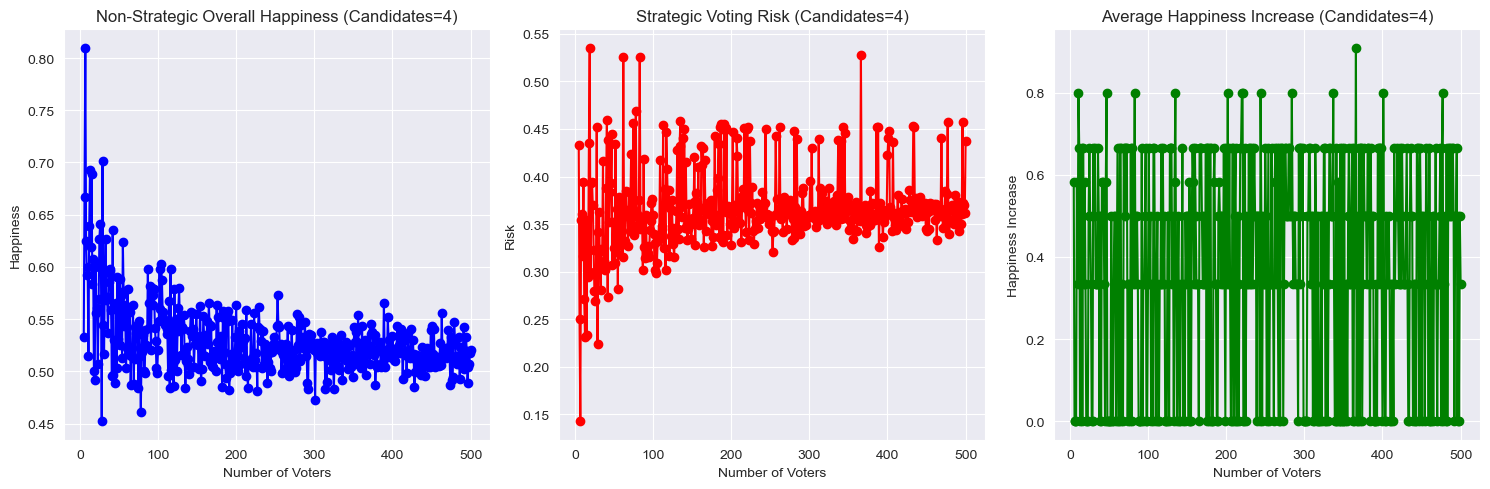

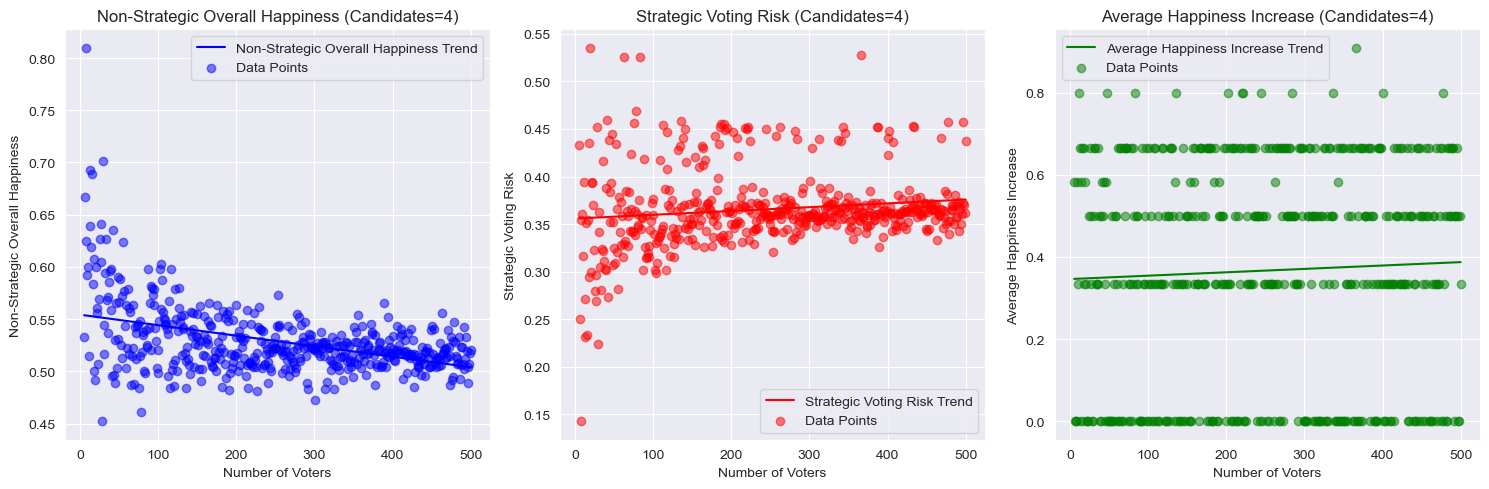

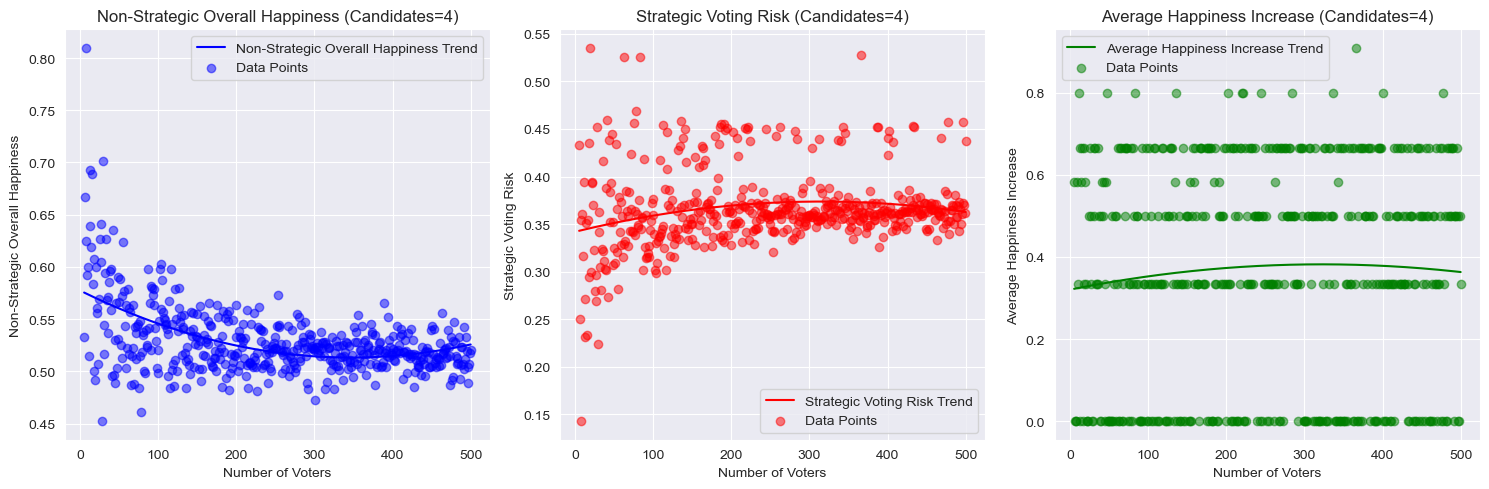

In [14]:
candidate_numbers = [4]  # Range of candidate numbers to test
voter_numbers = list(range(5, 501, 3))  # Range of voter numbers to test

results, voter_numbers = run_experiment(candidate_numbers, voter_numbers, schemes)
plot_combined_metrics(results, voter_numbers)
plot_combined_metrics_with_trends(results, voter_numbers)
plot_combined_metrics_with_nonlinear_trends(results, voter_numbers)

Running experiment for 5 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 10 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 15 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 20 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 25 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 30 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 35 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 40 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 45 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 50 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 55 voters
Number of candidates: 4
Results written to exp_o

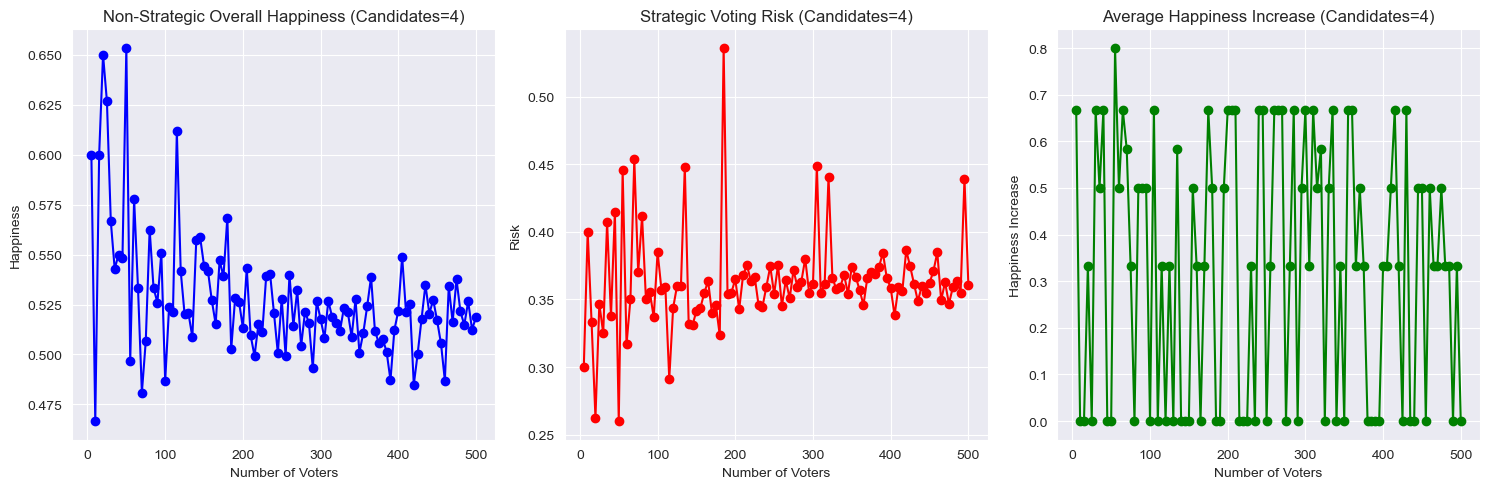

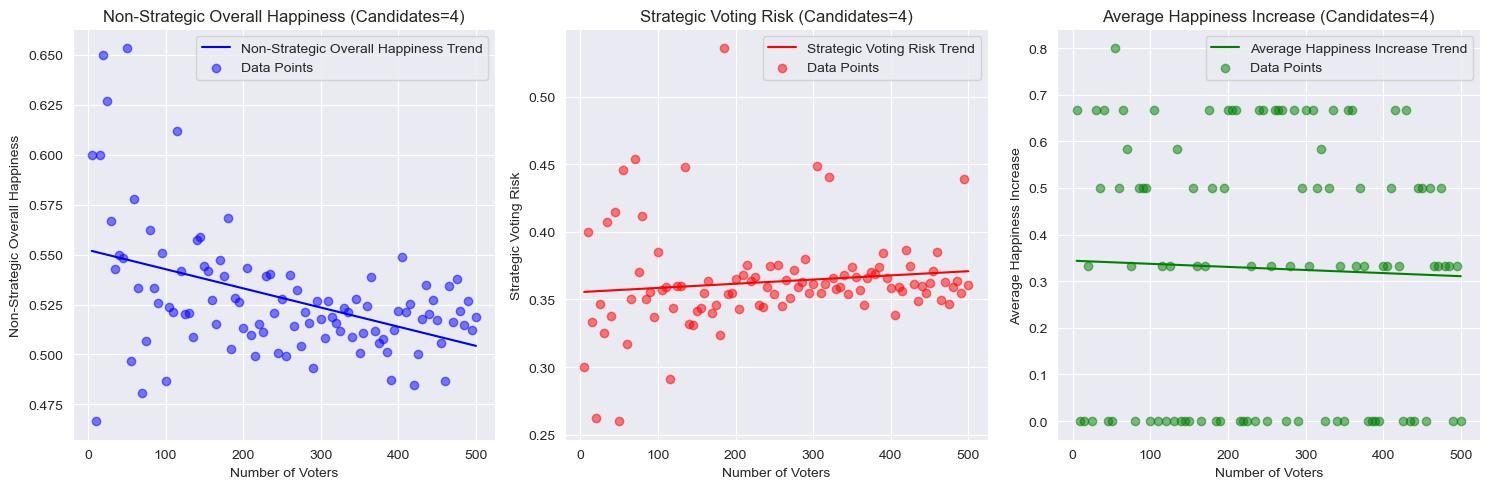

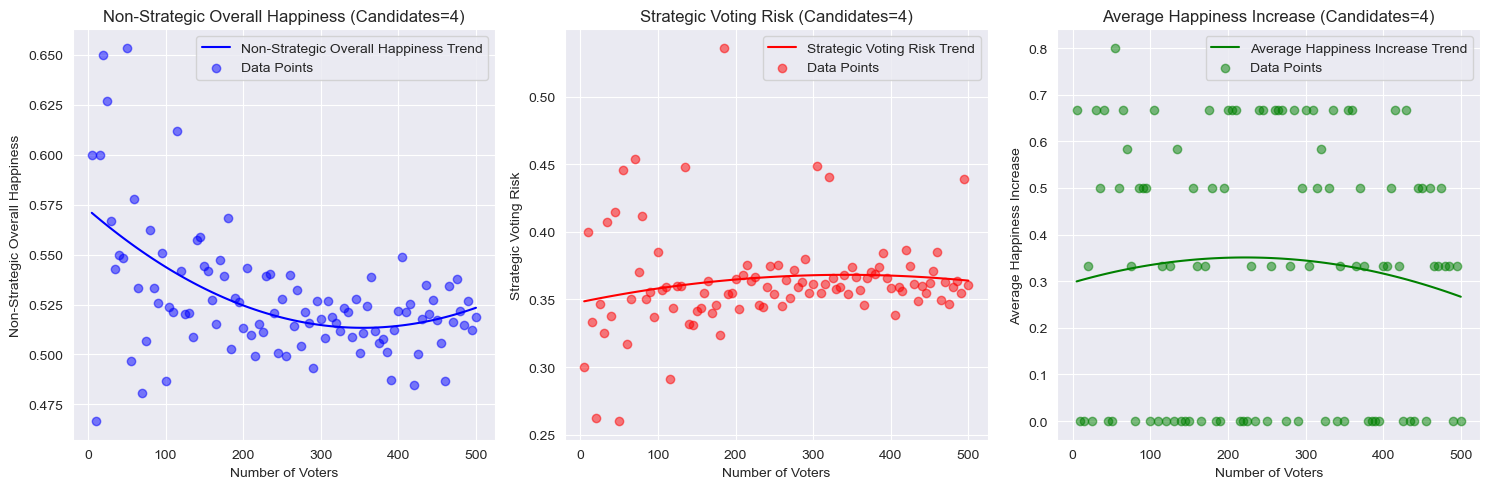

In [15]:

candidate_numbers = [4]  # Range of candidate numbers to test
voter_numbers = list(range(5, 501, 5))  # Range of voter numbers to test

results, voter_numbers = run_experiment(candidate_numbers, voter_numbers, schemes)
plot_combined_metrics(results, voter_numbers)
plot_combined_metrics_with_trends(results, voter_numbers)
plot_combined_metrics_with_nonlinear_trends(results, voter_numbers)